# Text Multiclass Classification based on BERT

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss # multi class loss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import AutoModel,AutoConfig,AutoTokenizer
from transformers import AutoModelForSequenceClassification, AdamW
from tqdm import tqdm, trange
from ast import literal_eval

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
device

device(type='cuda')

## Data Preprocessing

The Jigsaw Toxic Comment dataset comes from [Kaggle](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/rules). The training set contains comments with their binary labels. 


In [ ]:
df = pd.read_csv('./drive/MyDrive/Colab Notebooks/huggingface/datasets/toxic_tweet_data/train.csv') #jigsaw-toxic-comment-classification-challenge
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [ ]:
print('Unique comments: ', df.comment_text.nunique() == df.shape[0]) 
print('Null values: ', df.isnull().values.any())
# df[df.isna().any(axis=1)]

Unique comments:  True
Null values:  False


In [ ]:
df.shape[0]-df.count()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
print('average sentence length: ', df.comment_text.str.split().str.len().mean())
print('stdev sentence length: ', df.comment_text.str.split().str.len().std())

average sentence length:  67.27352714465661
stdev sentence length:  99.23070219290523


In [ ]:
df.comment_text.str.split().str.len().describe()

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_text, dtype: float64

In [ ]:
sum(df.comment_text.str.split().str.len()>200)

10087

In [ ]:
df.shape

(159571, 8)

In [ ]:
cols = df.columns 
label_cols = list(cols[2:]) # labels
num_labels = len(label_cols) # number of labels
print('Label columns: ', label_cols)

Label columns:  ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [ ]:
print('Count of 1 per label: \n', df[label_cols].sum(), '\n') 
print('Count of 0 per label: \n', df[label_cols].eq(0).sum())

Count of 1 per label: 
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64 

Count of 0 per label: 
 toxic            144277
severe_toxic     157976
obscene          151122
threat           159093
insult           151694
identity_hate    158166
dtype: int64


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df['one_hot_labels'] = list(df[label_cols].values) # one hot encode labels
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
0,2ae932b8fc3a999e,Unspecified source for Image:Wof_pic.jpg\n\nTh...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,4d489b38c78f8a21,"""\n\nAfD nomination of Chris D. Jackson\nChris...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2,8577f232edddfbc4,Did he? \n\nIs there any evidence that he DIDN...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3,9164b36a625d8ddb,OK! Let's just all agree that there is a disti...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
4,823bb316efd22c63,"Hmmmm, the Sandy strategy of maintaining good ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer lowercases
def token_len(sen):
  tokens = tokenizer.encode(sen, max_length = 300)
  return len(tokens)

df['len'] = df['comment_text'].map(token_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
df_select = df.iloc[np.where(df['len'] <= 50)].reset_index()
df_select

,index,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels,len
0,2,8577f232edddfbc4,Did he? \n\nIs there any evidence that he DIDN...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",40
1,4,823bb316efd22c63,"Hmmmm, the Sandy strategy of maintaining good ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",31
2,5,841da71419b5863a,He should have been in BFDI as Ice cube \n\nSa...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",14
3,6,00163c0c893b488f,Do not blank your page\nAgainst Wiki rules!,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",12
4,7,16a157f0041ea30c,Make the page of chance and real \n\nplease190...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",18
...,...,...,...,...,...,...,...,...,...,...,...
78140,159559,c8336e578bab9ee1,Feel free to include that within the article! ...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",15
78141,159561,a0ed388bade78646,Okay I think I fixed what Anma was complaining...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",29
78142,159565,ea811baaf7f222bd,and Crime in the Dominican Republic,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",8
78143,159567,7785f845381fc85d,December 2007 (UTC)\n\nCan't say we didn't war...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",30


In [ ]:
print('Count of 1 per label: \n', df_select[label_cols].sum(), '\n') 
print('Count of 0 per label: \n', df_select[label_cols].eq(0).sum())

Count of 1 per label: 
 toxic            9828
severe_toxic     1123
obscene          5648
threat            322
insult           5283
identity_hate     935
dtype: int64 

Count of 0 per label: 
 toxic            68317
severe_toxic     77022
obscene          72497
threat           77823
insult           72862
identity_hate    77210
dtype: int64


In [ ]:
labels = list(df_select.one_hot_labels.values)
comments = list(df_select.comment_text.values)

## Tokenization

Use per-trained BERT tokenizer to tokenize sentences into tokens, specify the max number of tokens in each sentence. 


BERT:  
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)   

XLNet:  
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)   

RoBERTa:  
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)

In [ ]:
train_length = []
for comm in comments:
  tokens = tokenizer.encode(comm, max_length=300)
  train_length.append(len(tokens))

max(train_length)

50

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


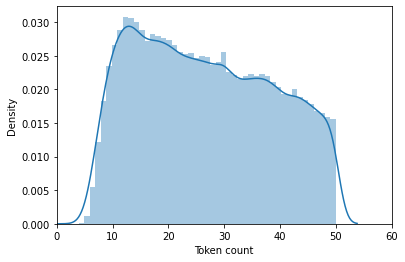

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(train_length)
plt.xlim([0, 60]);
plt.xlabel('Token count');

In [ ]:
max_length = 50
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer lowercases
encodings = tokenizer.batch_encode_plus(
    comments,
    max_length=max_length,
    pad_to_max_length=True
) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys()) 

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [ ]:
input_ids[0]

[101,
 2106,
 2002,
 1029,
 2003,
 2045,
 2151,
 3350,
 2008,
 2002,
 2134,
 1005,
 1056,
 3102,
 1996,
 1046,
 24316,
 1010,
 2672,
 1996,
 2030,
 23773,
 2389,
 8543,
 2001,
 3031,
 2242,
 2044,
 2035,
 1012,
 2023,
 2035,
 3504,
 2200,
 26489,
 6292,
 2000,
 2033,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
tokenizer.convert_ids_to_tokens(input_ids[0])

['[CLS]',
 'did',
 'he',
 '?',
 'is',
 'there',
 'any',
 'evidence',
 'that',
 'he',
 'didn',
 "'",
 't',
 'kill',
 'the',
 'j',
 '##fk',
 ',',
 'maybe',
 'the',
 'or',
 '##ign',
 '##al',
 'creator',
 'was',
 'onto',
 'something',
 'after',
 'all',
 '.',
 'this',
 'all',
 'looks',
 'very',
 'dod',
 '##gy',
 'to',
 'me',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
comments[0]

"Did he? \n\nIs there any evidence that he DIDN'T kill the JFK, maybe the orignal creator was onto something after all. This all looks very dodgy to me."

In [ ]:
label_counts = df_select.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_select[df_select.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [50826]


In [ ]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

## Construct Dataloader

Split dataset into training and validation set, and then construct the dataloader with pre-specified batch size.


In [ ]:
# Split dataset
train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids, attention_masks,random_state=2020, test_size=0.20, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# 8 16 32 64  128 256
batch_size = 128

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data) # 
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data) 
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
torch.save(validation_dataloader,'./drive/MyDrive/Colab Notebooks/huggingface/datasets/toxic_tweet_data/validation_data_loader')
torch.save(train_dataloader,'./drive/MyDrive/Colab Notebooks/huggingface/datasets/toxic_tweet_data/train_data_loader')

## Build Model 

Model Configuration:

AutoModel:  
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)  

BERT:  
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)  

XLNet:  
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)  

RoBERTa:  
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels) 
# num_labels：6 
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
paras=[para for para in model.named_parameters()]

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True)
# 1e-5,2e-5,5e-5
# optimizer = AdamW(model.parameters(),lr=2e-5) 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## Train Model

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# trange is a tqdm wrapper around the normal python range
for ep_ in trange(epochs, desc="Epoch"):
  print(f"Epoch: {ep_}")

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train() 

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    
    if step % 10 == 0:
      print(f"Step: {step}")

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    # 
    # train_inputs.extend(one_freq_input_ids)
    # train_labels.extend(one_freq_labels)
    # train_masks.extend(one_freq_attention_masks)
    # train_token_types.extend(one_freq_token_types)
    # 
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    
    loss_func = BCEWithLogitsLoss() 
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss() 
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item()) # record loss    

    # Backward pass
    loss.backward() 
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # 
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Step: 0
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100
Step: 110
Step: 120
Step: 130
Step: 140
Step: 150
Step: 160
Step: 170
Step: 180
Step: 190
Step: 200
Step: 210
Step: 220
Step: 230
Step: 240
Step: 250
Step: 260
Step: 270
Step: 280
Step: 290
Step: 300
Step: 310
Step: 320
Step: 330
Step: 340
Step: 350
Step: 360
Step: 370
Step: 380
Step: 390
Step: 400
Step: 410
Step: 420
Step: 430
Step: 440
Step: 450
Step: 460
Step: 470
Step: 480
Train loss: 0.1085205231021884


Epoch:  20%|██        | 1/5 [08:32<34:11, 512.76s/it]

F1 Validation Accuracy:  79.50700280112045
Flat Validation Accuracy:  90.79915541621345
Epoch: 1
Step: 0
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100
Step: 110
Step: 120
Step: 130
Step: 140
Step: 150
Step: 160
Step: 170
Step: 180
Step: 190
Step: 200
Step: 210
Step: 220
Step: 230
Step: 240
Step: 250
Step: 260
Step: 270
Step: 280
Step: 290
Step: 300
Step: 310
Step: 320
Step: 330
Step: 340
Step: 350
Step: 360
Step: 370
Step: 380
Step: 390
Step: 400
Step: 410
Step: 420
Step: 430
Step: 440
Step: 450
Step: 460
Step: 470
Step: 480
Train loss: 0.04886388534523836


Epoch:  40%|████      | 2/5 [17:06<25:39, 513.07s/it]

F1 Validation Accuracy:  81.16624040920716
Flat Validation Accuracy:  90.44724550515069
Epoch: 2
Step: 0
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100
Step: 110
Step: 120
Step: 130
Step: 140
Step: 150
Step: 160
Step: 170
Step: 180
Step: 190
Step: 200
Step: 210
Step: 220
Step: 230
Step: 240
Step: 250
Step: 260
Step: 270
Step: 280
Step: 290
Step: 300
Step: 310
Step: 320
Step: 330
Step: 340
Step: 350
Step: 360
Step: 370
Step: 380
Step: 390
Step: 400
Step: 410
Step: 420
Step: 430
Step: 440
Step: 450
Step: 460
Step: 470
Step: 480
Train loss: 0.038616274845365485


Epoch:  60%|██████    | 3/5 [25:39<17:06, 513.14s/it]

F1 Validation Accuracy:  81.28869765977541
Flat Validation Accuracy:  90.66478981380767
Epoch: 3
Step: 0
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100
Step: 110
Step: 120
Step: 130
Step: 140
Step: 150
Step: 160
Step: 170
Step: 180
Step: 190
Step: 200
Step: 210
Step: 220
Step: 230
Step: 240
Step: 250
Step: 260
Step: 270
Step: 280
Step: 290
Step: 300
Step: 310
Step: 320
Step: 330
Step: 340
Step: 350
Step: 360
Step: 370
Step: 380
Step: 390
Step: 400
Step: 410
Step: 420
Step: 430
Step: 440
Step: 450
Step: 460
Step: 470
Step: 480
Train loss: 0.031849963462898215


Epoch:  80%|████████  | 4/5 [34:12<08:33, 513.11s/it]

F1 Validation Accuracy:  82.22480702125411
Flat Validation Accuracy:  91.2022522234308
Epoch: 4
Step: 0
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100
Step: 110
Step: 120
Step: 130
Step: 140
Step: 150
Step: 160
Step: 170
Step: 180
Step: 190
Step: 200
Step: 210
Step: 220
Step: 230
Step: 240
Step: 250
Step: 260
Step: 270
Step: 280
Step: 290
Step: 300
Step: 310
Step: 320
Step: 330
Step: 340
Step: 350
Step: 360
Step: 370
Step: 380
Step: 390
Step: 400
Step: 410
Step: 420
Step: 430
Step: 440
Step: 450
Step: 460
Step: 470
Step: 480
Train loss: 0.02653844808637791


Epoch: 100%|██████████| 5/5 [42:45<00:00, 513.08s/it]

F1 Validation Accuracy:  81.65271966527197
Flat Validation Accuracy:  90.82474886429074


In [ ]:
torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/huggingface/bert_model_toxic')

## Prepare Test Data

In [ ]:
test_df = pd.read_csv('./drive/MyDrive/Colab Notebooks/huggingface/datasets/toxic_tweet_data/test.csv')
test_labels_df = pd.read_csv('./drive/MyDrive/Colab Notebooks/huggingface/datasets/toxic_tweet_data/test_labels.csv')
test_df = test_df.merge(test_labels_df, on='id', how='left')
test_label_cols = list(test_df.columns[2:])
print('Null values: ', test_df.isnull().values.any()) #should not be any null sentences or labels
print('Same columns between train and test: ', label_cols == test_label_cols) #columns should be the same
test_df.head()

Null values:  False
Same columns between train and test:  True


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [ ]:
test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)] #remove irrelevant rows/comments with -1 values
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [ ]:
# Gathering input data
test_labels = list(test_df.one_hot_labels.values)
test_comments = list(test_df.comment_text.values)

In [ ]:
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'./drive/MyDrive/Colab Notebooks/huggingface/datasets/toxic_tweet_data/test_data_loader')

## Evaluation and Prediction

In [ ]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

In [ ]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Test F1 Accuracy:  0.6537698697864267
Test Flat Accuracy:  0.8694082340804652 

               precision    recall  f1-score   support

        toxic       0.53      0.86      0.66      6090
 severe_toxic       0.32      0.59      0.41       367
      obscene       0.57      0.81      0.67      3691
       threat       0.55      0.48      0.52       211
       insult       0.66      0.71      0.68      3427
identity_hate       0.66      0.53      0.58       712

    micro avg       0.56      0.78      0.65     14498
    macro avg       0.55      0.66      0.59     14498
 weighted avg       0.57      0.78      0.65     14498
  samples avg       0.07      0.07      0.07     14498



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
idx2label = dict(zip(range(6),label_cols))
print(idx2label)

{0: 'toxic', 1: 'severe_toxic', 2: 'obscene', 3: 'threat', 4: 'insult', 5: 'identity_hate'}


In [ ]:
# Getting indices of where boolean one hot vector true_bools is True so we can use idx2label to gather label names
true_label_idxs, pred_label_idxs=[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools:
  pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

In [ ]:
# Gathering vectors of label names using idx2label
true_label_texts, pred_label_texts = [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in pred_label_idxs:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

In [ ]:
# Decoding input ids to comment text
comment_texts = [tokenizer.decode(text,skip_special_tokens=True,clean_up_tokenization_spaces=False) for text in tokenized_texts]

In [ ]:
# Converting lists to df
comparisons_df = pd.DataFrame({'comment_text': comment_texts, 'true_labels': true_label_texts, 'pred_labels':pred_label_texts})
comparisons_df.to_csv('comparisons.csv')
comparisons_df.head()

,comment_text,true_labels,pred_labels
0,thank you for understanding. i think very high...,[],[]
1,: dear god this site is horrible.,[],[toxic]
2,""" : : : somebody will invariably try to add re...",[],[]
3,""" it says it right there that it is a type. th...",[],[]
4,""" = = before adding a new product to the list,...",[],[]


### F1 score threshold search


You should optimize your model for recall if you want to decrease the number of false negatives. You should optimize your model for precision when you want to decrease the number of false positives.

F1 score is calculated by taking the harmonic mean of precision and recall and ranges from 0 to 1. Harmonic mean has a nice arithmetic property representing a truly balanced mean. If either precision or recall is low, it suffers significantly.

"If you have a high class imbalance, always choose the F1 score because a high F1 score considers both precision and recall." To get a high F1, both false positives and false negatives must be low. 

Reference:

https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

https://stats.stackexchange.com/questions/71700/how-to-draw-roc-curve-with-three-response-variable

https://www.datascienceblog.net/post/machine-learning/performance-measures-multi-class-problems/

In [ ]:
macro_thresholds = np.array(range(1,10))/10
macro_thresholds

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
f1_results, flat_acc_results = [], []
for th in macro_thresholds:
  pred_bools = [pl>th for pl in pred_labels]
  test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
  test_flat_accuracy = accuracy_score(true_bools, pred_bools)
  f1_results.append(test_f1_accuracy)
  flat_acc_results.append(test_flat_accuracy)

best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

f1_results, flat_acc_results = [], []
for th in micro_thresholds:
  pred_bools = [pl>th for pl in pred_labels]
  test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
  test_flat_accuracy = accuracy_score(true_bools, pred_bools)
  f1_results.append(test_f1_accuracy)
  flat_acc_results.append(test_flat_accuracy)

best_f1_idx = np.argmax(f1_results) #best threshold value

# Printing and saving classification report
print('Best Threshold: ', micro_thresholds[best_f1_idx])
print('Test F1 Accuracy: ', f1_results[best_f1_idx])
print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]
clf_report_optimized = classification_report(true_bools,best_pred_bools, target_names=label_cols)
pickle.dump(clf_report_optimized, open('classification_report_optimized.txt','wb'))
print(clf_report_optimized)

Best Threshold:  0.73
Test F1 Accuracy:  0.6644462947543713
Test Flat Accuracy:  0.8837256556941449 

               precision    recall  f1-score   support

        toxic       0.58      0.83      0.68      6090
 severe_toxic       0.46      0.22      0.30       367
      obscene       0.62      0.77      0.69      3691
       threat       0.72      0.22      0.33       211
       insult       0.74      0.61      0.67      3427
identity_hate       0.76      0.41      0.53       712

    micro avg       0.62      0.72      0.66     14498
    macro avg       0.65      0.51      0.53     14498
 weighted avg       0.63      0.72      0.66     14498
  samples avg       0.07      0.07      0.07     14498



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
